In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# le chemin où se trouve le fichier CSV nettoyé
base_path = './'
csv_file = os.path.join(base_path, 'combined_play_by_play_cleaned.csv')

def load_play_by_play_data(csv_file):
    """
    Load play-by-play data from a CSV file.
    """
    if os.path.exists(csv_file):
        return pd.read_csv(csv_file)
    else:
        print(f"File {csv_file} not found.")
        return None

data = load_play_by_play_data(csv_file)
if data is not None:
    print("Données chargées avec succès.")
else:
    print("Erreur lors du chargement des données.")


Données chargées avec succès.


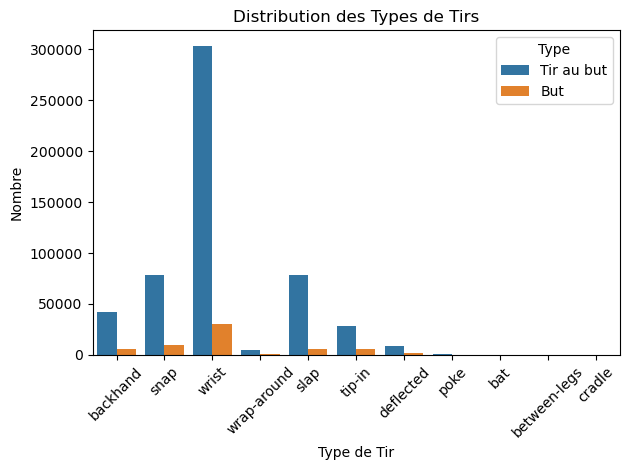

In [2]:
# Distribution des types de tirs
sns.countplot(data=data, x='Type de tir', hue='Type')
plt.title('Distribution des Types de Tirs')
plt.xlabel('Type de Tir')
plt.ylabel('Nombre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


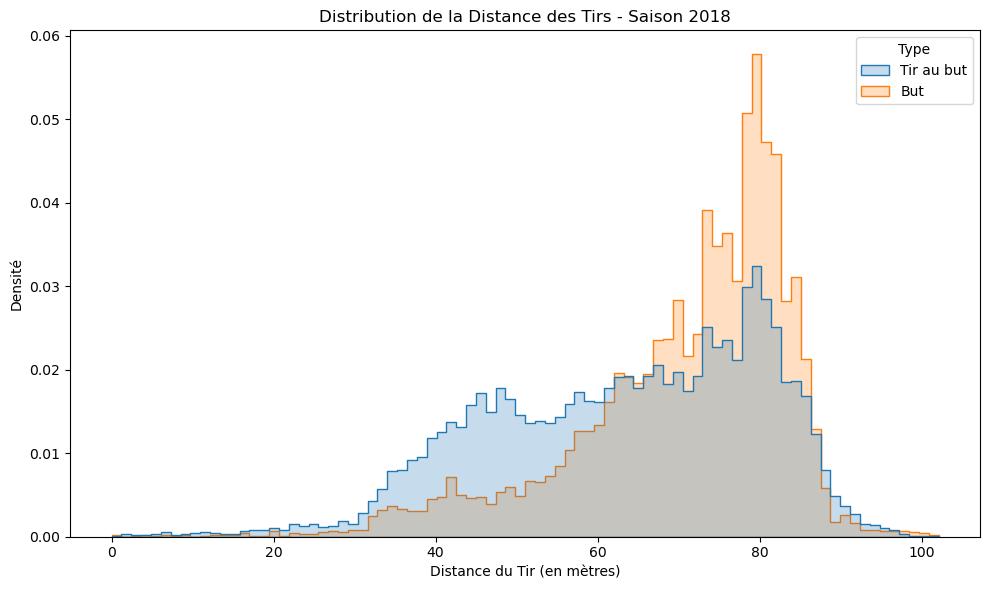

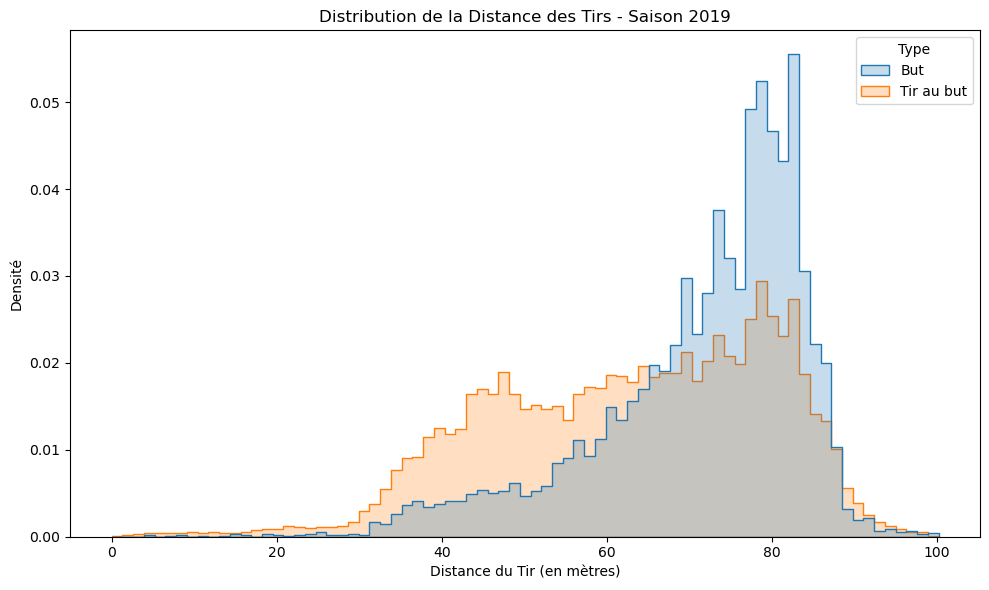

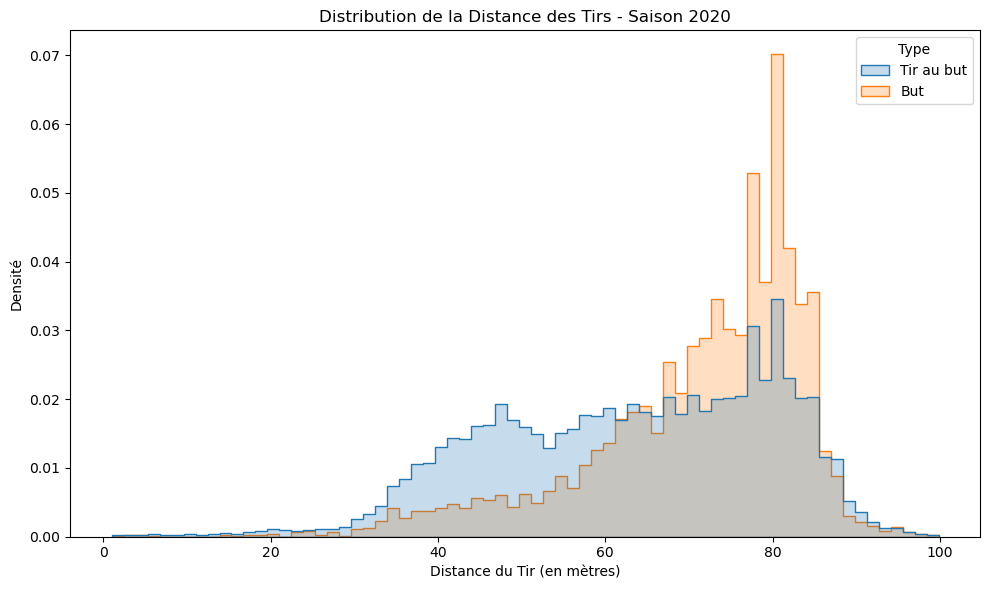

In [3]:
# Calculer la distance à partir des coordonnées x et y
data['Distance'] = np.sqrt(data['xCoord']**2 + data['yCoord']**2)

# Itérer sur les saisons pour générer un graphique pour chaque saison
seasons = ['2018', '2019', '2020']

for season in seasons:
    season_data = data[data['idGame'].astype(str).str.startswith(season)]
    
    if not season_data.empty:
        plt.figure(figsize=(10, 6))
        sns.histplot(season_data, x='Distance', hue='Type', element='step', stat='density', common_norm=False)
        plt.title(f'Distribution de la Distance des Tirs - Saison {season}')
        plt.xlabel('Distance du Tir (en mètres)')
        plt.ylabel('Densité')
        plt.tight_layout()
        plt.show()


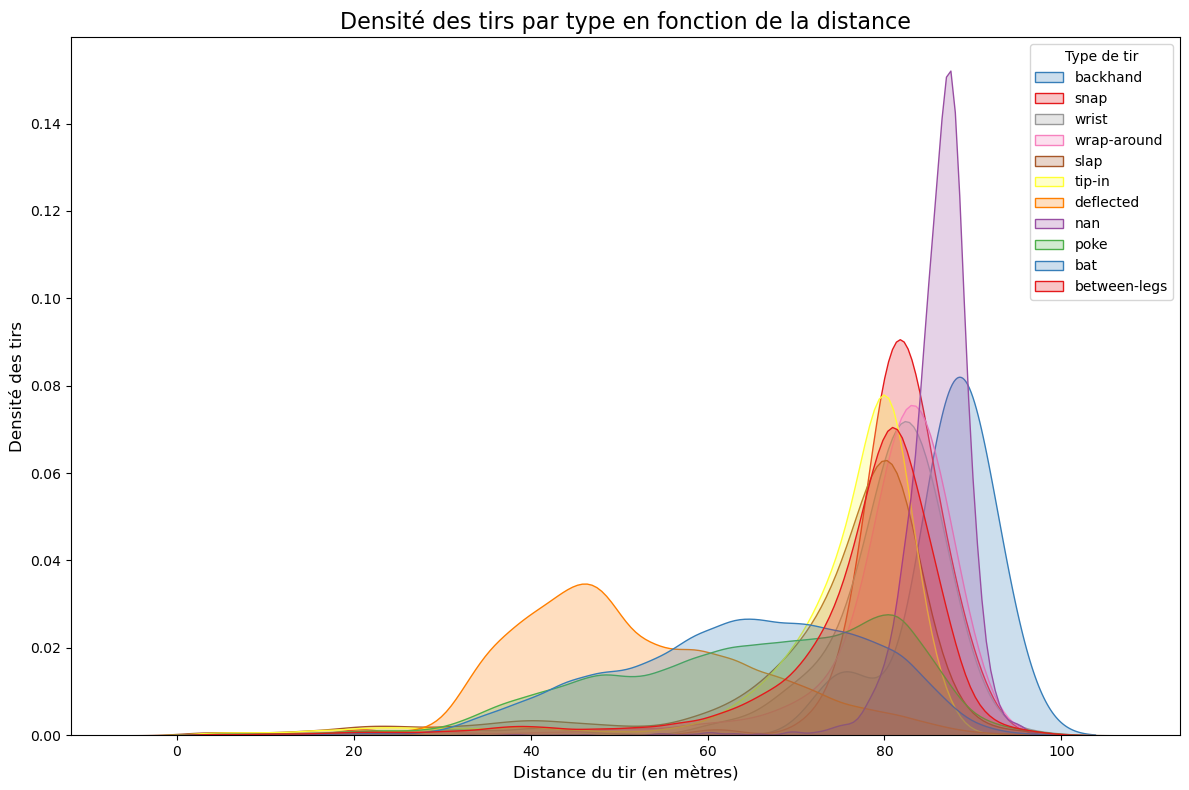

In [4]:
# Ajout d'une colonne indiquant si l'événement est un but
data['is_goal'] = data['Type'].apply(lambda x: 1 if x == 'But' else 0)

# Créer un graphique KDE pour chaque type de tir
plt.figure(figsize=(12, 8))

sns.kdeplot(data=data, x='Distance', hue='Type de tir', fill=True, common_norm=False, palette="Set1")
plt.title('Densité des tirs par type en fonction de la distance', fontsize=16)
plt.xlabel('Distance du tir (en mètres)', fontsize=12)
plt.ylabel('Densité des tirs', fontsize=12)
plt.legend(title="Type de tir", loc='upper right', labels=data['Type de tir'].unique())
plt.tight_layout()
plt.show()


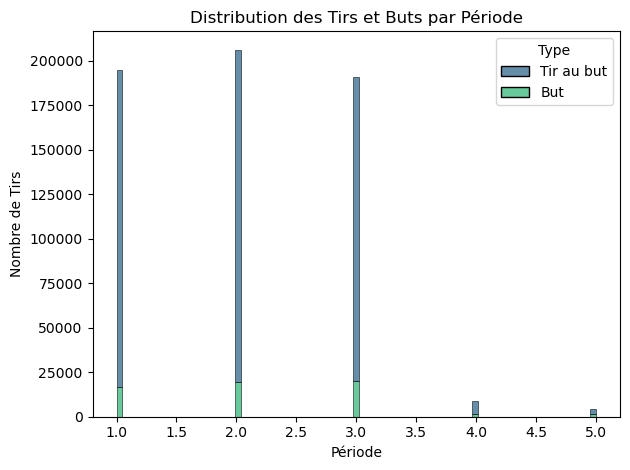

In [5]:
sns.histplot(data=data, x='Periode', hue='Type', multiple='stack', palette='viridis')
plt.title('Distribution des Tirs et Buts par Période')
plt.xlabel('Période')
plt.ylabel('Nombre de Tirs')
plt.tight_layout()
plt.show()


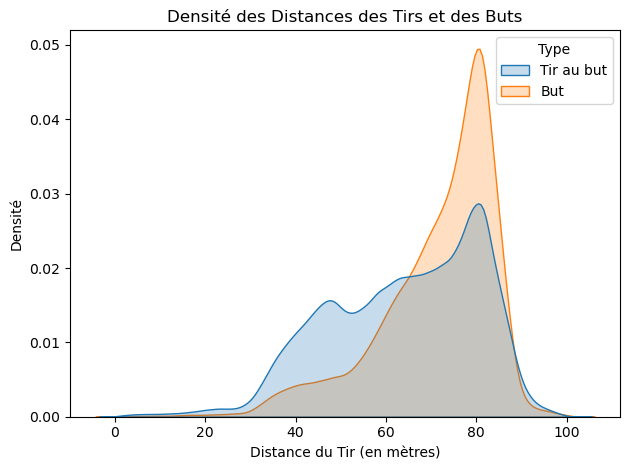

In [6]:
sns.kdeplot(data=data, x='Distance', hue='Type', fill=True, common_norm=False)
plt.title('Densité des Distances des Tirs et des Buts')
plt.xlabel('Distance du Tir (en mètres)')
plt.ylabel('Densité')
plt.tight_layout()
plt.show()


/tmp/ipykernel_328087/801989143.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = (df['xCoord']**2 + df['yCoord']**2) ** 0.5
/tmp/ipykernel_328087/801989143.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2019['distance_bin'] = pd.cut(data_2019['distance'], bins)


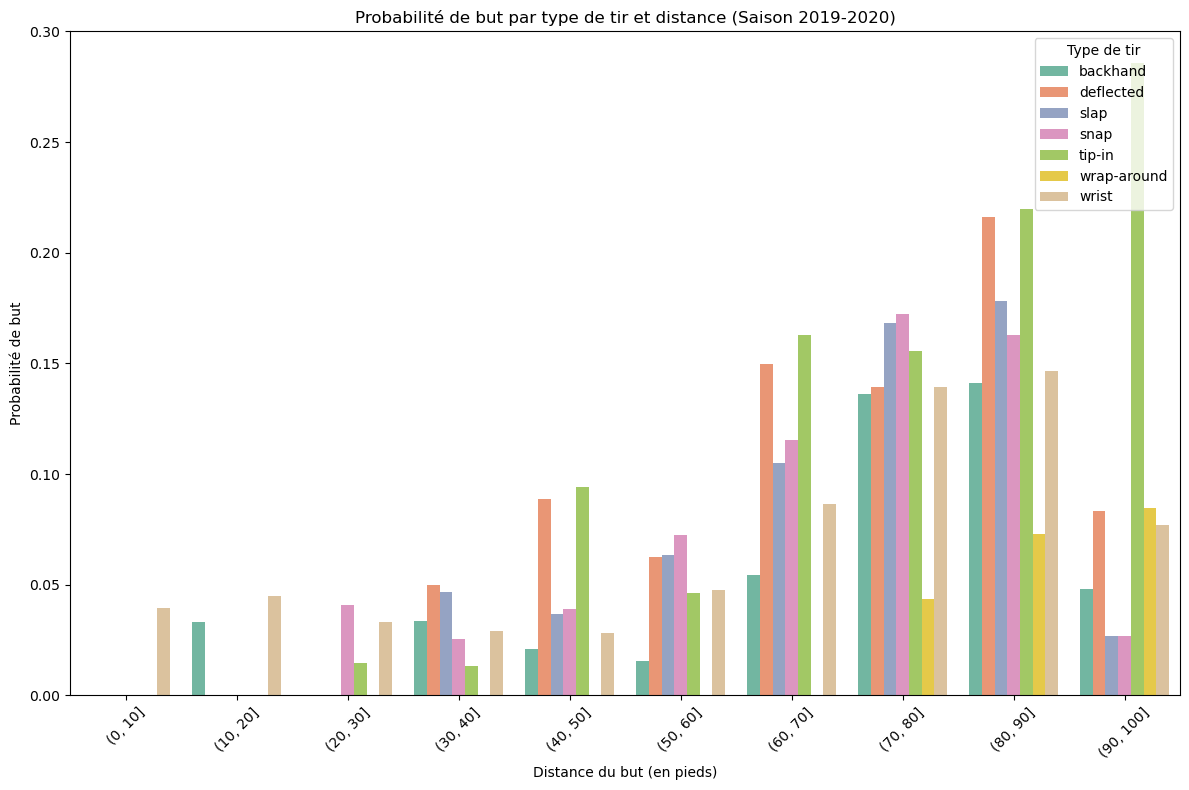

In [7]:
# Function to calculate distance
def calculate_distance(df):
    """
    Calcule la distance par rapport au but à partir des coordonnées x et y.
    
    :param df: DataFrame avec les colonnes 'xCoord' et 'yCoord'.
    :return: DataFrame avec une nouvelle colonne 'distance'.
    """
    df['distance'] = (df['xCoord']**2 + df['yCoord']**2) ** 0.5
    return df

data = load_play_by_play_data(csv_file)

# Convert 'idGame' to string if it is not already
data['idGame'] = data['idGame'].astype(str)

# Filter the data for the 2019-2020 season based on the 'idGame' field
data_2019 = data[data['idGame'].str.startswith('2019')]  # Filter for 2019 season

# Calculate distance
data_2019 = calculate_distance(data_2019)

# Create bins for distance
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
data_2019['distance_bin'] = pd.cut(data_2019['distance'], bins)

df_combined = data_2019.groupby(['distance_bin', 'Type de tir']).agg(
    total_shots=('Type', 'count'),
    total_goals=('Type', lambda x: (x == 'But').sum())
).reset_index()

# Calculate goal probability
df_combined['goal_probability'] = df_combined['total_goals'] / df_combined['total_shots']

plt.figure(figsize=(12, 8))
sns.barplot(data=df_combined, x='distance_bin', y='goal_probability', hue='Type de tir', palette='Set2')
plt.title('Probabilité de but par type de tir et distance (Saison 2019-2020)')
plt.xlabel('Distance du but (en pieds)')
plt.ylabel('Probabilité de but')
plt.legend(title='Type de tir', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Ajuster les Coordonnées des Tirs

In [8]:
# Fonction pour ajuster les coordonnées en fonction de la période
def adjust_coordinates(df):
    df['xCoord_adj'] = df.apply(lambda row: -row['xCoord'] if row['Periode'] == 2 else row['xCoord'], axis=1)
    return df

# Ajuster les coordonnées
data = adjust_coordinates(data)


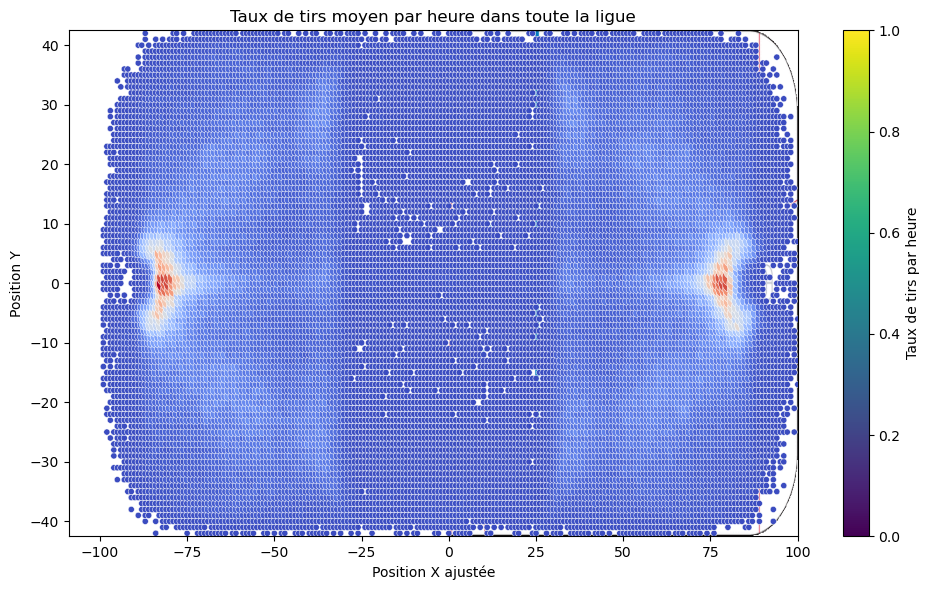

In [9]:
rink_image_path = '/home/mohamed/project-template/figures/nhl_rink.png'
rink_img = plt.imread(rink_image_path)

shots_by_location = data.groupby(['xCoord_adj', 'yCoord']).size().reset_index(name='total_shots')

# Calculer le nombre total de matchs
number_of_games = data['idGame'].nunique()

# Supposer que chaque match dure 60 minutes
total_hours_played = number_of_games * 1  # 1 heure par match

# Calculer le taux de tirs moyen par heure pour chaque emplacement
shots_by_location['shot_rate_per_hour'] = shots_by_location['total_shots'] / total_hours_played

# Visualiser les taux de tir moyens par emplacement
plt.figure(figsize=(10, 6))
plt.imshow(rink_img, extent=[0, 100, -42.5, 42.5], aspect='auto', zorder=0)

# Tracer les taux de tir moyens par emplacement sur la glace
sns.scatterplot(
    data=shots_by_location, 
    x='xCoord_adj', 
    y='yCoord', 
    size='shot_rate_per_hour', 
    hue='shot_rate_per_hour', 
    palette='coolwarm', 
    sizes=(20, 200), 
    legend=False,
    zorder=1
)

plt.title('Taux de tirs moyen par heure dans toute la ligue')
plt.xlabel('Position X ajustée')
plt.ylabel('Position Y')

plt.colorbar(label='Taux de tirs par heure')

plt.tight_layout()

plt.show()


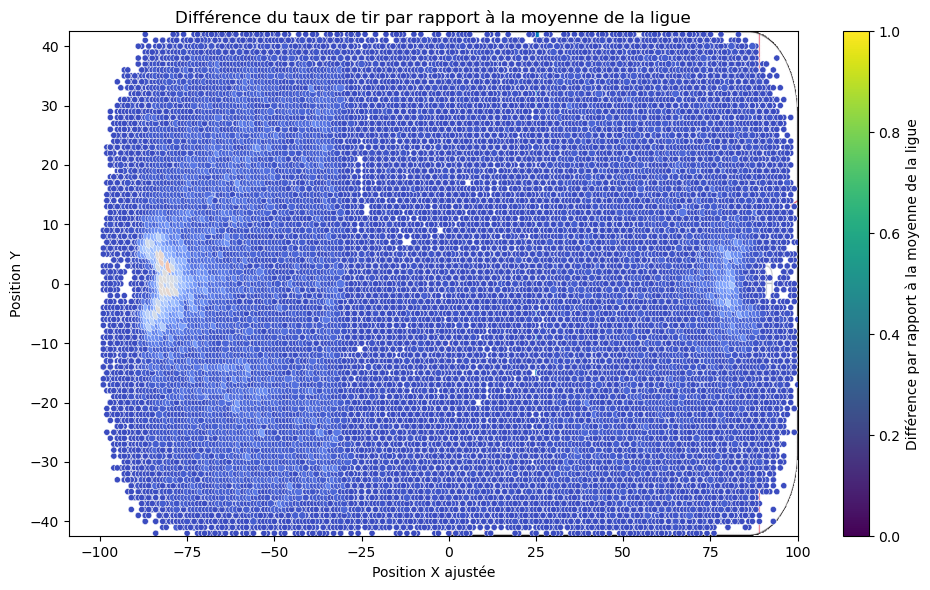

In [10]:
rink_image_path = '/home/mohamed/project-template/figures/nhl_rink.png'
rink_img = plt.imread(rink_image_path)

# Calcul de la moyenne de la ligue
league_avg_shot_rate = shots_by_location['shot_rate_per_hour'].mean()

# Comparer le taux de tir des équipes avec la moyenne de la ligue
team_shots = data.groupby(['Equipe', 'xCoord_adj', 'yCoord']).size().reset_index(name='total_shots')
team_shots['shot_rate_per_hour'] = team_shots['total_shots'] / total_hours_played
team_shots['diff_from_league_avg'] = team_shots['shot_rate_per_hour'] - league_avg_shot_rate

plt.figure(figsize=(10, 6))

plt.imshow(rink_img, extent=[0, 100, -42.5, 42.5], aspect='auto', zorder=0)

sns.scatterplot(
    data=team_shots, 
    x='xCoord_adj', 
    y='yCoord', 
    size='diff_from_league_avg', 
    hue='diff_from_league_avg', 
    palette='coolwarm', 
    sizes=(20, 200), 
    legend=False,
    zorder=1 
)


plt.title('Différence du taux de tir par rapport à la moyenne de la ligue')
plt.xlabel('Position X ajustée')
plt.ylabel('Position Y')


plt.colorbar(label='Différence par rapport à la moyenne de la ligue')

plt.tight_layout()

plt.show()


In [11]:
from scipy.stats import gaussian_kde
import ipywidgets as widgets
from IPython.display import display

# Fonction pour créer la heatmap dynamique par équipe et saison
def plot_team_season_heatmap(team, season):
    # Filtrer les données pour l'équipe et la saison sélectionnées
    data_team_season = data[(data['Equipe'] == team) & (data['idGame'].str.startswith(season))]

    # Filtrer uniquement les situations 5v5 (force égale)
    data_5v5 = data_team_season[data_team_season['Situation'] == 'force egale']

    # Extraire les coordonnées des tirs dans la zone offensive (xCoord > 0)
    data_offensive_zone = data_5v5[data_5v5['xCoord'] > 0]

    # S'assurer qu'il n'y a pas de valeurs NaN
    x = data_offensive_zone['xCoord'].dropna()
    y = data_offensive_zone['yCoord'].dropna()

    if x.empty or y.empty:
        print(f"Aucune donnée disponible pour l'équipe {team} et la saison {season}.")
    else:
        # Estimation par noyau gaussien pour la densité des tirs
        kde = gaussian_kde([x, y], bw_method=0.15)

        # Créer une grille pour la patinoire (en pieds)
        x_grid = np.linspace(0, 100, 100)  # Seulement la zone offensive
        y_grid = np.linspace(-42.5, 42.5, 100)
        X, Y = np.meshgrid(x_grid, y_grid)
        Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

        # Tracer la heatmap avec les contours
        plt.figure(figsize=(8, 6))

        # Charger une image de la patinoire de hockey (fond)
        rink_image_path = '/home/mohamed/project-template/figures/nhl_rink.png'  # Remplacez par votre propre image de patinoire
        img = plt.imread(rink_image_path)
        plt.imshow(img, extent=[0, 100, -42.5, 42.5], aspect='auto')

        # Heatmap
        contour = plt.contourf(X, Y, Z, levels=20, cmap='coolwarm', alpha=0.6)
        cbar = plt.colorbar(contour)
        cbar.set_label('Excess shots per hour')

        # Ajouter le titre et les axes
        plt.title(f'Heatmap des tirs offensifs 5v5 de {team} - Saison {season}')
        plt.xlabel('Distance depuis le centre (en pieds)')
        plt.ylabel('Distance depuis la ligne de but (en pieds)')

        # Ajouter des contours supplémentaires
        plt.contour(X, Y, Z, levels=np.linspace(-0.5, 0.5, 11), colors='black', linewidths=0.5)

        # Afficher la figure
        plt.tight_layout()
        plt.show()

teams = data['Equipe'].unique()
seasons = ['2016','2017','2018', '2019', '2020','2021']

# Créer des widgets pour sélectionner une équipe et une saison
team_selector = widgets.Dropdown(
    options=teams,
    value=teams[0],
    description='Équipe:',
    disabled=False,
)

season_selector = widgets.Dropdown(
    options=seasons,
    value=seasons[0],
    description='Saison:',
    disabled=False,
)

widgets.interact(plot_team_season_heatmap, team=team_selector, season=season_selector)


interactive(children=(Dropdown(description='Équipe:', options=('Canadiens', 'Maple Leafs', 'Capitals', 'Bruins…

<function __main__.plot_team_season_heatmap(team, season)>

In [12]:
from IPython.display import display

rink_image_path = '/home/mohamed/project-template/figures/nhl_rink.png'
rink_img = plt.imread(rink_image_path)

def plot_team_vs_league_shot_rate(team):
    team_data = data[data['Equipe'] == team]
    team_shots = team_data.groupby(['xCoord_adj', 'yCoord']).size().reset_index(name='total_shots')
    team_shots['shot_rate_per_hour'] = team_shots['total_shots'] / total_hours_played
    team_shots['diff_from_league_avg'] = team_shots['shot_rate_per_hour'] - league_avg_shot_rate

    plt.figure(figsize=(10, 6))
    
    plt.imshow(rink_img, extent=[0, 100, -42.5, 42.5], aspect='auto', zorder=0)

    sns.scatterplot(
        data=team_shots, 
        x='xCoord_adj', 
        y='yCoord', 
        size='diff_from_league_avg', 
        hue='diff_from_league_avg', 
        palette='coolwarm', 
        sizes=(20, 200), 
        legend=False,
        zorder=1  
    )

    
    plt.title(f'Différence du taux de tir de {team} par rapport à la moyenne de la ligue')
    plt.xlabel('Position X ajustée')
    plt.ylabel('Position Y')

    # Ajouter une barre de couleur pour la différence par rapport à la moyenne de la ligue
    plt.colorbar(label='Différence par rapport à la moyenne de la ligue')

    # Ajuster la mise en page
    plt.tight_layout()
    
    # Afficher le graphique
    plt.show()

# Sélection de l'équipe pour afficher les différences de taux de tir
team_selector_diff = widgets.Dropdown(
    options=teams,  
    value=teams[0],
    description='Équipe:',
    disabled=False,
)


widgets.interact(plot_team_vs_league_shot_rate, team=team_selector_diff)


interactive(children=(Dropdown(description='Équipe:', options=('Canadiens', 'Maple Leafs', 'Capitals', 'Bruins…

<function __main__.plot_team_vs_league_shot_rate(team)>

In [17]:

import plotly.graph_objects as go
data['idGame'] = data['idGame'].astype(str)
data['distance'] = np.sqrt(data['xCoord']**2 + data['yCoord']**2)

seasons = ['2016', '2017', '2018', '2019', '2020']

def plot_offensive_zone(team, season, view):
    # Filtrer les données pour l'équipe et la saison
    season_data = data[(data['Equipe'] == team) & (data['idGame'].str.startswith(season))]
    
    # Filtrer pour la zone offensive (X > 0)
    offensive_zone_data = season_data[season_data['xCoord'] > 0]
    
    if offensive_zone_data.empty:
        print(f"Pas de données pour l'équipe {team} en saison {season}.")
        return
    
    # Créer une grille pour les coordonnées X et Y (zone offensive)
    x_edges = np.linspace(0, 100, 100)  # Seulement la moitié offensive
    y_edges = np.linspace(-42.5, 42.5, 100)
    x_midpoints = (x_edges[:-1] + x_edges[1:]) / 2
    y_midpoints = (y_edges[:-1] + y_edges[1:]) / 2
    
    # Calculer la densité des tirs
    heatmap, x_bins, y_bins = np.histogram2d(offensive_zone_data['xCoord'], offensive_zone_data['yCoord'], bins=[x_edges, y_edges])

    # Créer la figure Plotly
    fig = go.Figure()

    if view == '3D Surface':
        # Ajouter la surface 3D
        fig.add_trace(go.Surface(
            z=heatmap.T,  # Transposé pour aligner les axes
            x=x_midpoints,
            y=y_midpoints,
            colorscale="Plasma",
            contours={"z": {"show": True, "start": 0, "end": np.max(heatmap), "size": np.max(heatmap)/10}}
        ))
    else:
        # Ajouter la heatmap 2D
        fig.add_trace(go.Heatmap(
            z=heatmap.T,
            x=x_midpoints,
            y=y_midpoints,
            colorscale="Plasma"
        ))

    # Mise en page
    fig.update_layout(
        title=f'{view} Offensive des Tirs - {team} (Saison {season})',
        width=800,
        height=900,
        autosize=False,
        margin=dict(t=40, b=0, l=0, r=0),
        template="plotly_white",
        scene=dict(
            xaxis_title='Position X',
            yaxis_title='Position Y',
            zaxis_title='Densité des tirs'
        )
    )
    fig.show()


team_selector = widgets.Dropdown(
    options=data['Equipe'].unique(),
    value=data['Equipe'].unique()[0],
    description='Équipe:',
    disabled=False,
)

season_selector = widgets.Dropdown(
    options=seasons,
    value=seasons[0],
    description='Saison:',
    disabled=False,
)

view_selector = widgets.Dropdown(
    options=['3D Surface', 'Heatmap'],
    value='3D Surface',
    description='Vue:',
    disabled=False,
)
widgets.interact(plot_offensive_zone, team=team_selector, season=season_selector, view=view_selector)


interactive(children=(Dropdown(description='Équipe:', options=('Canadiens', 'Maple Leafs', 'Capitals', 'Bruins…

<function __main__.plot_offensive_zone(team, season, view)>